In [2]:
# Import Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from datetime import date, time, datetime, timedelta
from dateutil.relativedelta import relativedelta

# Allow us to create Flask app
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

In [19]:
# Retrieve the last 12 months of precipitation data by finding the maximum date in the table and subtracting one year.
# Select average prcp value by date and date.
max_date = session.query(func.max(func.strftime("%Y/%m/%d", Measurement.date))).all()
max_date = datetime.strptime(max_date[0][0], "%Y/%m/%d").date()

sel = [Measurement.date, func.avg(Measurement.prcp)]

prcp_twelve_months = session.query(*sel).\
    filter(Measurement.date >= (max_date - relativedelta(years=1))).\
    group_by(Measurement.date).all()
#print(prcp_twelve_months)

# Exploratory Climate Analysis

In [48]:
# Convert selected data to be loaded into a Pandas Dataframe

prcp_twelve_months_dict = dict(prcp_twelve_months)

prcp_twelve_months_df = pd.DataFrame.from_dict(prcp_twelve_months_dict, orient='index', dtype=None)

prcp_twelve_months_df = prcp_twelve_months_df.reset_index()
prcp_twelve_months_df.columns = ['date', 'prcp']
prcp_twelve_months_df = prcp_twelve_months_df.set_index('date')
prcp_twelve_months_df

,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
2016-08-29,0.243333
2016-08-30,0.011667
2016-08-31,0.636000


In [34]:
# Use Pandas to give summary statistics of precipitation data
prcp_twelve_months_df.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


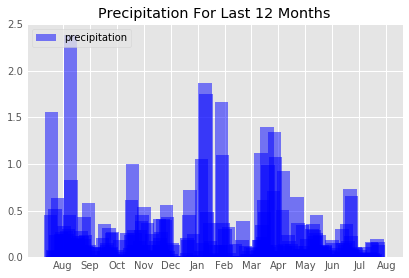

In [32]:
# Define labels
plt.title("Precipitation For Last 12 Months")

# Define months for x-ticks labels
months = ["Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr","May", "Jun", "Jul", "Aug"]

# Define X and Y values
x_axis = np.arange(0, len(prcp_twelve_months_df))
y_axis = prcp_twelve_months_df["prcp"]

# Define X-tick labels (months) and their positioning
total_entries = len(prcp_twelve_months_df["prcp"].tolist())
month_ticks = int(total_entries / 12)
tick_locations = [x+20 for x in range(1, total_entries, month_ticks)]

# Define plot
plt.bar(x_axis, y_axis, width=15, color="blue", alpha=0.5, align="edge")
plt.xticks(tick_locations, months)
plt.legend(["precipitation"],loc="upper left")
#plt.style.use('ggplot')

plt.show()

![precipitation](Images/precipitation.png)

![describe](Images/describe.png)

In [35]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Station.station).count()
number_of_stations

9

In [51]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [Station.station, Station.name, func.count(Measurement.tobs)]

activity_desc = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
    
activity_desc

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [37]:
# Display most active station
most_active_station = activity_desc[0][0:2]
most_active_station

('USC00519281', 'WAIHEE 837.5, HI US')

In [40]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = [Measurement.station, Measurement.tobs]

tobs_twelve_months = session.query(*sel).\
    filter(Measurement.station == most_active_station[0]).\
    filter(Measurement.date >= (max_date - relativedelta(years=1))).all()
    
#print(tobs_twelve_months)

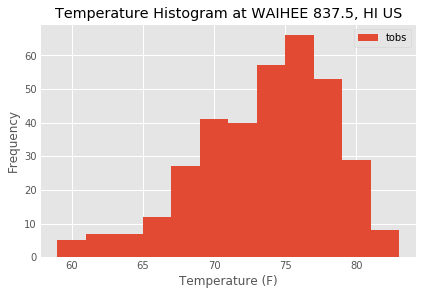

In [41]:
# Plot a histogram of frequency of temperature observations for most active station

temps = [x[1] for x in tobs_twelve_months]
plt.hist(temps, bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Histogram at %s" % (most_active_station[1]))
plt.legend(["tobs"],loc="upper right")
plt.show()

![precipitation](Images/station-histogram.png)

In [53]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-05-15', '2017-05-23'))

[(68.0, 74.70588235294117, 87.0)]


In [54]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# Test example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [55]:
# Use the calc_temps function to calculate temperatures for target date range using matching dates from previous year
# Given that my trip is planned for May 15-23, 2018:

trip_estimate = calc_temps('2017-05-15', '2017-05-23')
#print(trip_estimate)


# Assign variables to temperatures

min_temp = trip_estimate[0][0]
avg_temp = trip_estimate[0][1]
max_temp = trip_estimate[0][2]

# Output

print(f'Min Temp = {min_temp}')
print(f'Avg Temp = {avg_temp:.2f}')
print(f'Max Temp = {max_temp}')


Min Temp = 68.0
Avg Temp = 74.71
Max Temp = 87.0


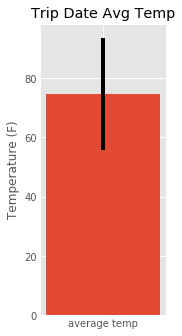

In [56]:
# Create bar chart of results

plt.figure(figsize=(2,5))
plt.title("Trip Date Avg Temp")
plt.ylabel("Temperature (F)")
plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "average temp")
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
